In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

from IPython.display import display
	# make it not fail in terminal execution

In [2]:
# Dataset
from torchvision import datasets

flowers_orig_train = datasets.Flowers102('./data', download=True, split="train")
flowers_orig_test = datasets.Flowers102('./data', download=True, split="test")
flowers_orig_val = datasets.Flowers102('./data', download=True, split="val")

# Show sizes
def analyze_size(imgs):
	flowers_sizes = pd.DataFrame([img.size for img, _ in imgs])
	flowers_sizes.columns = ["height", "width"]
	grouped_df = flowers_sizes.groupby(["height", "width"]).size().reset_index(name='count')
	display(grouped_df.head()) # Images don't have same sizes
	# show min width and height
	print("min height", flowers_sizes["height"].min())
	print("min width", flowers_sizes["width"].min())

analyze_size(flowers_orig_train)
analyze_size(flowers_orig_test)
analyze_size(flowers_orig_val)

,height,width,count
0,500,500,12
1,500,501,1
2,500,502,3
3,500,505,4
4,500,506,1


min height 500
min width 500


,height,width,count
0,500,500,41
1,500,501,2
2,500,502,9
3,500,503,4
4,500,504,6


min height 500
min width 500


,height,width,count
0,500,500,17
1,500,501,3
2,500,502,2
3,500,503,1
4,500,505,1


min height 500
min width 500


In [3]:
# Merge train, test, val
def collectData():
	# We need to transform before merging to avoid high memory consumption

	# Data cleansing

	# Crop to same size
	# Resize for consumer gpu
	# To tensor for neural network
	# Make mean 0 to match noise's mean
	from torchvision.transforms.v2 import CenterCrop
	transform = transforms.Compose([
		transforms.CenterCrop(500),
		transforms.Resize(64),
		transforms.ToTensor(),
		transforms.Lambda(lambda img: (img - 0.5) * 2)
	])

	train = datasets.Flowers102('./data', download=True, split='train', transform=transform)
	test = datasets.Flowers102('./data', download=True, split='test', transform=transform)
	val = datasets.Flowers102('./data', download=True, split='val', transform=transform)

	# Data contains classification
	def remove_target_and_to_numpy(data):
		return np.array( [img.numpy() for img, target in data] )
	train = remove_target_and_to_numpy(train)
	test = remove_target_and_to_numpy(test)
	val = remove_target_and_to_numpy(val)
	print(train.shape)
	print(test.shape)
	print(val.shape)

	# Concatenate them
	all = np.concatenate((train, test, val), axis=0)
	print(all.shape)
	return all
flowerTensors = collectData()

# Reverse transform
tensorToImage = transforms.Compose([
	transforms.Lambda(lambda img: img / 2 + 0.5),
	transforms.Lambda(lambda img: img.permute(1, 2, 0).numpy() * 255),
	transforms.Lambda(lambda img: img.astype(np.uint8))
])

(1020, 3, 64, 64)
(6149, 3, 64, 64)
(1020, 3, 64, 64)
(8189, 3, 64, 64)


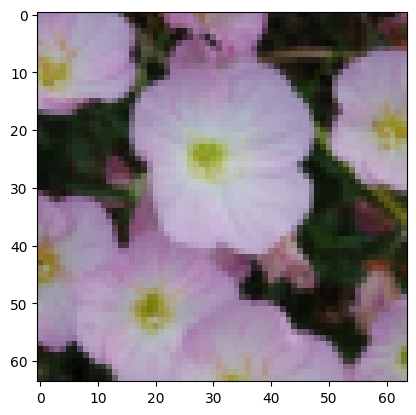

In [4]:
plt.imshow(tensorToImage(torch.from_numpy(flowerTensors[0])))

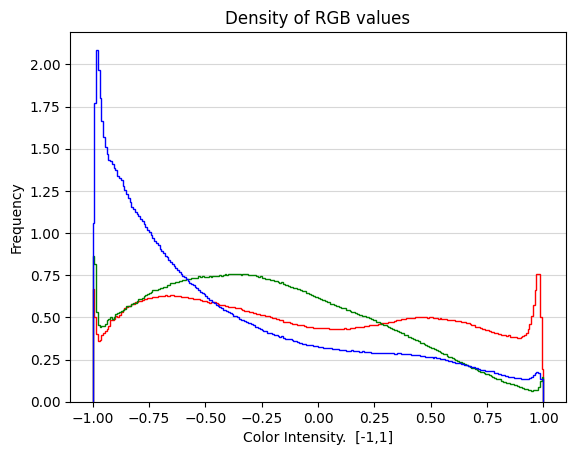

In [14]:
# Data analysis

# Distribution of (normalized) pixels
def img_histogram(data):
	for i, color in enumerate(["red", "green", "blue"]):
		plt.hist(data[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	plt.title('Density of RGB values')
	plt.xlabel('Color Intensity.  [-1,1]')
	plt.ylabel('Frequency')
	plt.grid(axis='y', alpha=0.5)
	plt.show()
img_histogram(flowerTensors)

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(flowerTensors, test_size=0.2, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=42)
print(train.shape)
print(test.shape)
print(val.shape)

(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)


In [ ]:
# Check if distribution is similar between train, test, val
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, dataset in enumerate([train, test, val]):
	for i, color in enumerate(["red", "green", "blue"]):
		axs[idx].hist(dataset[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	axs[idx].set_title('Density of RGB values') # can't use existing function because it's not .title 🙃
	axs[idx].set_xlabel('Color Intensity.  [-1,1]') # ...
	axs[idx].set_ylabel('Frequency') # ...
	axs[idx].grid(axis='y', alpha=0.5)
plt.show()

In [6]:
# gyakorlat: docker hogyan
# cleansing (kép szórás eloszlás, kicsik kidobása)

np.random.seed(42)
torch.manual_seed(42)

# todo: fix random
# baseline legyen mintavételezés az eloszlásból
# vae baseline, test on own gpu

# T db gauss zaj hozzáadás: várh érték függ az előző képtől?: https://huggingface.co/blog/annotated-diffusion
# variancia változik minden üzemben (~learning rate schedule)
# lehetne hiperparaméter a beta scheduler is (lineáris, exponenciális)

# Releváns laborok: Gépi labor 4. VAE
# Jó levezetés: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/